# SECS implementation i Python with `secsy`

Create a figure illustrating Python implementation spherical elementary current system (SECS) analysis on a cubed sphere grid (Figure 4 in code paper) using `lompe.secsy`. This is the basis of the Lompe technique, and this module is used in `lompe.model`.

We show how the implementation of SECS can be used to relate the now familiar [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model electric potential (Notebooks 01 and 02) to magnetic perturbations on ground.

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import numpy as np
import pandas as pd
import datetime as dt
import apexpy
import matplotlib.pyplot as plt
from lompe.secsy import get_SECS_B_G_matrices

Re = 6371.2e3                   # [m] Earth's radius
HI = 110e3                      # [m] Ionospheric altitude

#### Set up cubed sphere grid

Set up cubed sphere (CS) projection and grid. Note that we are working in magnetic coordinates (mlat, mlon) in this example. (NB: For Lompe applications, the grid must be set up in geographic coordinates as background magnetic field calculations etc. are done as if the grid was defined in geographic.)

In [3]:
L, W, Lres, Wres = 18000e3, 18000e3, 80e3, 80e3
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI)        # set grid to ionospheric altitude

We can visualize where the grid is located by plotting grid and coastlines:

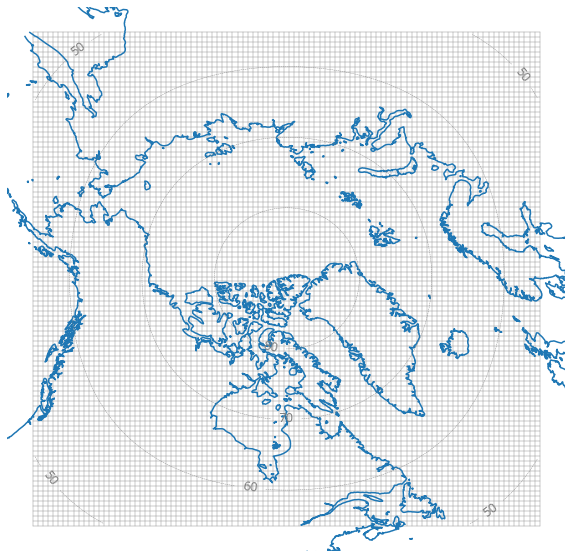

In [6]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_axis_off()

# grid
time = dt.datetime(2005, 9, 10)     # time for coastline plot
a = apexpy.Apex(time, refh=HI*1e-3) # reference altitude in km
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()

# coastlines
a = apexpy.Apex(time, refh=0)
for cl in grid.projection.get_projected_coastlines(mag=True, apex=a):
    ax.plot(cl[0], cl[1], color = 'C0')

# add (magnetic) latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(co, co.levels, inline = True, fontsize = 12)

ax.set_xlim(xlim)
ax.set_ylim(ylim);

#### Constant ionospheric conductances

For the purposes of this example, we set the Pedersen $\Sigma_P$ and Hall $\Sigma_H$ conductances to a constant $10\ \mathrm{moh}$ across the entire grid (unrealistic values):

In [4]:
SH = np.ones(grid.shape)*10 # [moh]
SP = np.ones(grid.shape)*10 # [moh]

This assumption is the basis of how we can relate an ionospheric electric potential to magnetic field perturbations on ground.

#### Electric potential to FACs

In Notebook 01, we calculated the divergence of the ionospheric electric field, $\bar{E}_{\nabla\cdot}$, from a [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model potential interpolated to the center of the $N$ cells in the `CSgrid`, $\bar{\Phi}$. We want to use this divergence to represent FACs, $j_{||}$. We have conductances that are constant across the grid, and therefore no gradients of the Pedersen and Hall conductance. Thus the FACs and $\nabla\cdot\mathbf{E}$ can be related through ([Reistad et al. 2019](https://doi.org/10.1029/2019JA026634))

\begin{equation*}
    j_{||} = \Sigma_P\nabla\cdot\mathbf{E}
\end{equation*}


NOTE: This is derived from taking the divergence of the (horizontal) ionospheric current density $\nabla\cdot\mathbf{J}_{\perp}$ from the height-integrated Ohm's law, $\mathbf{J}_{\perp}=\Sigma_P\mathbf{E}+\Sigma_H\hat{\mathbf{b}}\times\mathbf{E}$ (with $\nabla\Sigma_P=\nabla\Sigma_H=0$). The use of the ionospheric Ohm's law implies steady-state, and that $\nabla\times\mathbf{E}=0$.

We load the $\bar{E}_{\nabla\cdot}$ which we derived from the Weimer potential in Notebook 01 (note that we can do this as the grid in Notebook 01 is identical to the grid we set up earlier in this example):

In [5]:
# load div(E)
df = pd.read_hdf('./datasets/01divE.h5')
divE = (df['divE'].values).reshape(grid.shape)

# calculate FACs
FAC = divE*SH

#### FACs to curl-free SECS amplitudes

We relate the FACs (unit: Ampere per m$^2$) to curl-free (CF) amplitudes of SECS basis functions for the current densities, $\mathbf{S}^{\star}$ (unit: Ampere) by multiplying with the grid cell areas, $A$:
\begin{equation*}
    \mathbf{S}^{\star}=j_{||}\cdot A
\end{equation*}

In [6]:
CF_amp = FAC*grid.A

#### Curl-free to divergence-free SECS amplitudes

As there are no conductance gradients along the electric field, and the Hall-to-Pedersen conductance ratio is a constant, the CF amplitudes and divergence-free (DF) SECS amplitudes $\mathbf{S}^{\circ}$ are related through:
\begin{equation}
\begin{split}
    j_{||}&=-\frac{1}{\alpha}\left(\nabla\times\mathbf{J}^{\circ}\right)_r \\
    \mathbf{S}^{\star}&=-\frac{1}{\alpha}\mathbf{S}^{\circ}
\end{split}
\end{equation}
where $\mathbf{J}^{\circ}$ is the curl-free component of the horizontal current (Equation 5 in [Amm et al. 2002](https://doi.org/10.1029/2002JA009472)). The Hall-to-Pedersen conductance ratio is $\alpha=\Sigma_H/\Sigma_P=1$, and the field-aligned currents, $j_{||}=\nabla\cdot\mathbf{J}_{\perp}$, are inversely proportional to the radial component of the curl of the DF part of the horizontal currents $\mathbf{J}_{\perp}$.

We can therefore obtain the DF amplitudes through $\mathbf{S}^{\circ}=-\mathbf{S}^{\star}$:

In [7]:
DF_amp = -CF_amp

#### Divergence-free SECS amplitudes to magnetic field disturbances 

The DF current are what can be observed as magnetic disturbances on ground $\Delta\tilde{\mathbf{B}}_g$, and we relate $\mathbf{S}^{\circ}$ to these disturbances through:
\begin{equation*}
    \Delta\tilde{\mathbf{B}}_g=\mathbb{H}^{\circ}_g\mathbf{S}^{\circ}
\end{equation*}

We use the vectorized implementation of the SECS basis functions to find the matrix $\mathbb{H}^{\circ}_g$ that relates the divergence-free amplitudes to the magnetic field on ground. $\mathbb{H}^{\circ}_g$ has elements from Equations 10-12 in the Lompe paper ([Laundal et al. 2022](https://doi.org/10.1029/2022JA030356)).

In [8]:
# limit for singularity correction is half a grid cell
secs_singularity_limit = np.min([grid.Wres, grid.Lres])/2

He_mat, Hn_mat, Hu_mat = get_SECS_B_G_matrices(np.ravel(grid.lat_mesh), np.ravel(grid.lon_mesh), Re, 
                                               np.ravel(grid.lat), np.ravel(grid.lon), RI = grid.R,
                                               current_type = 'divergence_free', 
                                               singularity_limit = secs_singularity_limit)

We set the evaluation points offset from the grid centers (in the corners of the grid cells) to further mitigate the singularity-problem of the SECS basis functions. The radius of evaluation points is set to the Earth radius.

Note that $\mathbb{H}^{\circ}_g=\begin{pmatrix}\mathbb{H}^{\circ}_{ge} \\ \mathbb{H}^{\circ}_{gn}\\ \mathbb{H}^{\circ}_{gu} \end{pmatrix}$.

We can now calculate the magntic field disturbances on ground using the above equation. (This is then the magnetic disturbance on ground that would result from the Weimer model potential in an ionosphere with constant Pedersen and Hall conductances of 10 moh.)

In [9]:
Bge, Bgn, Bgu = He_mat.dot(DF_amp.flatten()), Hn_mat.dot(DF_amp.flatten()), Hu_mat.dot(DF_amp.flatten())

#### Plotting

We can visualize the ground magnetic field projected on a grid ($\xi, \eta$ coordinates):

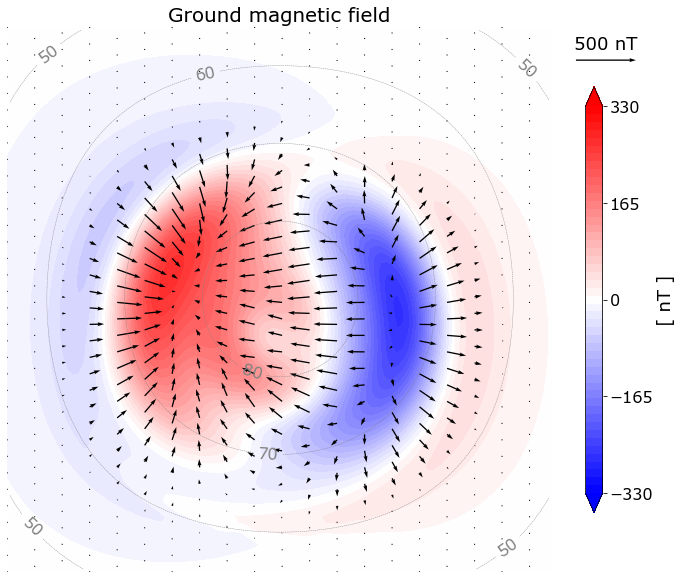

In [51]:
# set up figure
fig = plt.figure(figsize=(10,8.5))
ax  = fig.add_subplot(111)
ax.set_title('Ground magnetic field', fontsize = 20)
ax.set_aspect('equal')
ax.axis('off')

# magnetic latitude contours
c = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', 
               linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(c, c.levels, inline = True, fontsize = 16)

# define some scales for color
scale = 600 * 1e-9                       # scale for horizontal east, north components [T]
scale_units = 'inches'                   # horizontal component
colorscale = np.linspace(-330, 330, 50)  # upward component
ticks = np.linspace(-330, 330, 5)        # scale for upward component color bar [nT]

# transform horizontal components from (east, north) to CS (xi,eta) system
x, y, Ax, Ay = grid.projection.vector_cube_projection(Bge.reshape(grid.lon_mesh.shape), 
                                                      Bgn.reshape(grid.lon_mesh.shape), grid.lon_mesh, grid.lat_mesh)

# plot horizontal vectors for some of the evaluation locations
SKIP = 15
q=ax.quiver(x[::SKIP], y[::SKIP], Ax[::SKIP], Ay[::SKIP], scale = scale, scale_units=scale_units, color='black')
ax.quiverkey(q, 1.1, .94, U=500e-9, label='500 nT', fontproperties={'size':18})   # add scale for vectors

# plot upward component and colorbar
Bgu = Bgu.reshape(grid.eta_mesh.shape)
c=ax.contourf(grid.xi_mesh, grid.eta_mesh, Bgu*1e9, cmap=plt.cm.bwr, levels=colorscale, zorder=0, extend='both')
cbar=fig.colorbar(c, ax=ax, ticks=ticks, orientation='vertical', shrink=0.7, aspect=25)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('[ nT ]', fontsize=18)

fig.subplots_adjust(left=.05, right=.995, bottom=.001, top=.995)

# save figure
fig.savefig('./output_figures/SECSexample.pdf')
fig.savefig('./output_figures/SECSexample.png')

The figure shows the ground magnetic field disturbances resulting from an ionosphere with the electric potential as the [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model. 

The color scale is the upward component (blue is downlard, red is upward), and the arrows show the horizontal components of the magnetic disturbance on ground. 

Note that this is the same way the ground magnetic field perturbations are illustrated in a `lompeplot` (e.g., Notebook 07, or notebooks in /lompe_paper_figures/). 